## RNN 文本分类
1. 这一部分使用深度学习模型处理文本（序列）数据，一般用于处理序列数据的基本方法是使用 RNN 
2. 本次内容搭建简单的 RNN 模型实现文本分类（IMDB数据集）
3. 文本分类在一些基本的自然语言处理任务中起到了而非常重要的作用
    * 情感分析
    * 文档分类
    * 意图识别

In [111]:
# load packages
import numpy as np
import tensorflow as tf
import tensorflow
import keras
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
gpu_option = tf.GPUOptions(allow_growth=True)
%matplotlib inline

### 1. 处理文本数据
* 和其他的神经网络一样，深度学习模型不是接受原始的文本作为输入，只能处理张量数据
* 将纯文本映射为张量数据是非常重要的一个环节，这部分我们来讨论一下如何预处理文本数据为神经网络可以接受的形式
* 文本向量化的方法
    1. 文本分割为单词，每一个单词对应一个向量
    2. 文本分割为字符，每一个字符对应一个向量
    3. 提取词组（n-gram）作为一个向量 **n-gram 是多个连续单词的或者字符的集合**
* 文本向量化得到的每一个单元成为 **token**，这一个过程称之为是 **tokenization**
*文本向量化方法
    * one-hot
    * word embedding

#### 1.1 One-hot 
one-hot 编码是将单词转换成项链的最简单的方法，每一个单词和一个唯一的整数索引相关联，将整数索引 $i$ 转换成长度为 $N$ 的二进制向量（$N$ 是词表的大小），这个向量中只有第 $i$ 个元素是 1 其他都是0，所以叫做 one-hot 编码。

对于句子，one-hot编码的方式就是长度为 $N$ 的单词，其中句子中出现过的单词对应的索引的元素是 1 其他都是 0。

In [2]:
def make_dict(inpt):
    # inpt: 输入序列
    # ['The cat sat on the mat.', 'The dog ate my homework']
    # 返回的 token 中索引从1开始计数，0当作pad的token
    tokens_dict = {}
    for sample in inpt:
        for word in sample.split():
            if word not in tokens_dict:
                tokens_dict[word] = len(tokens_dict) + 1
    return tokens_dict

In [3]:
def make_one_hot(inpt, token_dict, max_length=10):
    # maxx_length: 文本的最大长度
    one_hots = np.zeros([len(inpt), max_length, max(token_dict.values()) + 1])    # [B, T, E]
    for i, sample in enumerate(inpt):
        for j, word in list(enumerate(sample.split()))[:max_length]:
            index = token_dict.get(word, None)
            one_hots[i, j, index] = 1.
    return one_hots

下面我们测试一下自己编写的 one-hot 编码生成的例子

In [4]:
samples = ['我 正在 学习 深度学习', '我 爱 自然语言处理', 'RNN 真 简单']
token_dict = make_dict(samples)
token_dict

{'我': 1,
 '正在': 2,
 '学习': 3,
 '深度学习': 4,
 '爱': 5,
 '自然语言处理': 6,
 'RNN': 7,
 '真': 8,
 '简单': 9}

In [5]:
one_hots = make_one_hot(samples, token_dict, max_length=5)
one_hots

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

我们实现了简单的文本处理，但是 tensorflow (keras) 已经为我们提供了开箱即用的工具自动生成 one-hot 编码，我们下面学习一下如何使用这个接口

In [6]:
# 导入 keras 预处理工具
from keras.preprocessing.text import Tokenizer

In [7]:
tokenizer = Tokenizer(num_words=10)    # 创建分词器
tokenizer.fit_on_texts(samples)        # 构建词表

In [8]:
sequences = tokenizer.texts_to_sequences(samples)    # 生成索引编码
sequences

[[1, 2, 3, 4], [1, 5, 6], [7, 8, 9]]

In [9]:
one_hot_ = tokenizer.texts_to_matrix(samples, mode='binary')    # 句子的 one-hot 表示
one_hot_

array([[0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]])

#### 1.2 word embedding
word embedding 是另外一种文本向量化的方法，之前我们提到的 one-hot 编码是二进制的编码，非常的稀疏（绝大多数元素是0）维度也很高。表示的语义信息非常少，为了解决这个问题。一种新的密集型向量化方法就可以获得更好的性能。就是 word embedding 方法。文本嵌入的词向量是低维的（100~300，相对于词表1w的1w维one-hot编码方法比）。并且可以得到非常有用的稠密语义信息。**词向量的每一维都有对应的语义信息，表示一个语义上的特征，比如情感，句式，主题等等。**

![](https://camo.githubusercontent.com/8f1074670908ed80281db8c5feeca28d306f1bd8/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368362f776f72645f656d62656464696e67732e706e67)

这种方法也开启了自然语言处理中预训练模型的研究方向
* word2vec
* ELMo
* GloVe
* GPT
* **BERT**
* ERINE

获得 word embedding 的方法
* 在小数量下，使用预训练的 word embedding 会得到非常大的性能提升
* 在大数据量下这样的提升不是很显著，一般大家习惯在大语料的情况下使用随机初始化的 word embedding 在任务训练过程中同时训练 word embedding 词向量。

In [10]:
# 导入 embedding 层
from keras.layers import Embedding

$$\rm Index \rightarrow \rm Embedding\ layer \rightarrow \rm Word\ Embedding$$

In [11]:
# 里面存储了 1000x100 的映射矩阵，存储这每一个单词对应的低维词向量
# 1000 表示词表大小，64 表示嵌入的维度
embedding_layer = Embedding(1000, 100)

我们现在讨论一下 Embedding 层的使用方式是什么样子的
* Embedding 层的输入是二维整数向量，输入的 shape 是 (samples, sequence_length)，例如输入的矩阵是 (32, 10) 表示的是32个长度为10的句子
* 因为之后的神经网络需要统一的输入格式，虽然自然语言每一句话的长度肯定不会相同，但是我们尽量要求输入必须是一样长的，这样 gpu 或者 cpu 上的加速算法才可以起到作用，上面的例子中，强制要求每一个句子长度是 10 ，不足10的我们用特殊token补足10个单词(padding)，超过10的我们强行截断。
* Embedding 层的输出是三维张量 (samples, sequence_length, embedding_dim)的三维浮点张量，这批张量后续可以被 RNN 层进行处理
* Embedding 层创建的时候参数是随机初始化的，但是也支持后续 load 上预训练的词向量模型，我们稍后探讨这一点

### 2. 数据集加载
我们这部分采用 IMDB 数据集进行文本分类的任务

IMDB 数据集是一个测试二分类的效果的数据集，包含有 25000 个句子，每一个句子都被分为两类，要么是0(消极评论)，要么是1(积极评论)

In [161]:
from keras.datasets import imdb
from keras import preprocessing
max_features = 10000    # 词表大小限制为 10000,多了截取频率最高的前10000个单词
maxlen = 50    # 每句最多 100 个单词

In [162]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [163]:
# 25000 个句子，与处理成长度都是 20 的矩阵
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
x_train.shape, x_test.shape

((25000, 50), (25000, 50))

### 3. 使用简单的 MLP 神经网络的分类方法
在进入RNN实战教学之前，我们先用最简单的方法处理文本分类

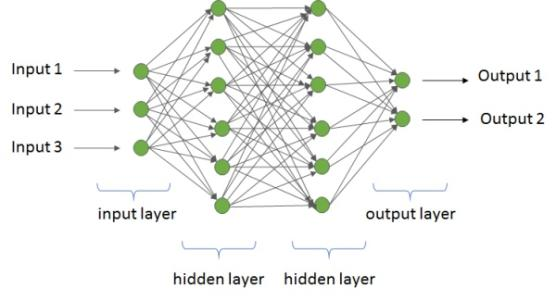

In [164]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

In [165]:
model = Sequential()
model.add(Embedding(max_features, 50, input_length=maxlen))    # 添加 embedding 层, [samples, 20, 100]

In [166]:
# 最简单的方法，一个句子的 embedding 表示就是所有的单词的 embedding 表示的拼接
# 平坦化一个句子的 embedding，[samples, 20 * 100]
model.add(Flatten())

In [167]:
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    # 添加 sigmoid 作 二分类

In [168]:
# model 开始编译，使用 rmsprop 梯度下降优化器
# 使用二分类交叉熵损失
# 评估指标选用 accuracy 精准度
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [169]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
flatten_7 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 100)               250100    
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 101       
Total params: 750,201
Trainable params: 750,201
Non-trainable params: 0
_________________________________________________________________


In [170]:
from keras.utils.vis_utils import plot_model
plot_model(model, './image/model1.png')

![](./image/model1.png)

In [171]:
# trian the model
history = model.fit(x_train,
                    y_train, 
                    epochs=50, 
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 1s 62us/step - loss: 0.5262 - acc: 0.7309 - val_loss: 0.4320 - val_acc: 0.8014
Epoch 2/50
20000/20000 [==============================] - 1s 26us/step - loss: 0.2886 - acc: 0.8804 - val_loss: 0.4382 - val_acc: 0.8032
Epoch 3/50
20000/20000 [==============================] - 1s 25us/step - loss: 0.1392 - acc: 0.9556 - val_loss: 0.5400 - val_acc: 0.7872
Epoch 4/50
20000/20000 [==============================] - 1s 25us/step - loss: 0.0367 - acc: 0.9919 - val_loss: 0.6999 - val_acc: 0.7734
Epoch 5/50
20000/20000 [==============================] - 1s 26us/step - loss: 0.0047 - acc: 0.9994 - val_loss: 0.9349 - val_acc: 0.7752
Epoch 6/50
20000/20000 [==============================] - 1s 26us/step - loss: 6.9768e-04 - acc: 0.9999 - val_loss: 1.1355 - val_acc: 0.7706
Epoch 7/50
20000/20000 [==============================] - 1s 26us/step - loss: 2.1305e-05 - acc: 1.0000 - val_loss: 1.3169 - 

In [172]:
def plot_history(history):
    def plot_item(item, ax, label):
        ax.plot(list(range(len(item))), item, label=label)
        
    # four subplots
    plt.figure(figsize=(15, 7.5))
    ax1 = plt.subplot(121)
    ax1.set_title('Loss')
    plot_item(history.history['val_loss'], ax1, 'val_loss')
    plot_item(history.history['loss'], ax1, 'loss')
    ax1.legend()
    
    ax2 = plt.subplot(122)
    ax2.set_title('Acc')
    plot_item(history.history['val_acc'], ax2, 'val_acc')
    plot_item(history.history['acc'], ax2, 'acc')
    ax2.legend()

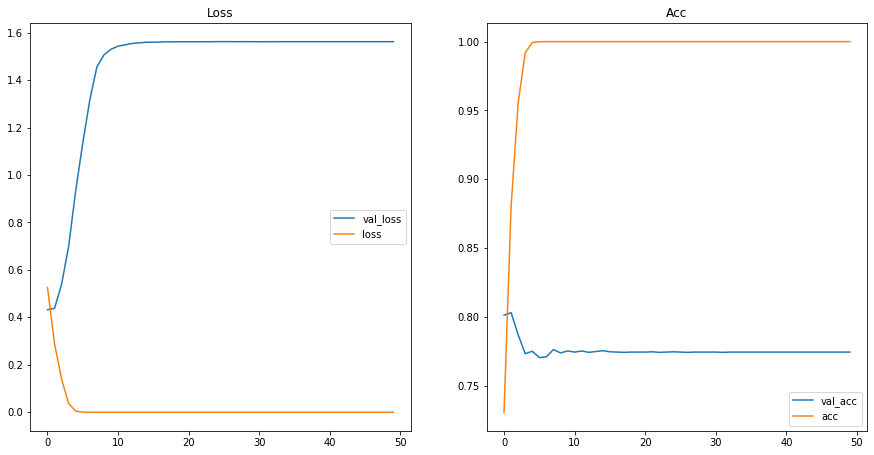

In [173]:
plot_history(history)

我们可以发现，这种最简单的方法，验证集上的精度（模型的效果）大约是71%，和随机的 50%相比是很高了，但是还不够。因为我们之查看了评论的前20个单词。这样一方面会损失很多的信息。另外我们直接将所有单词的 embedding 拼接起来作为句子的表示，这样的方法也会损失很多的序列信息。

In [174]:
model.evaluate(x_test, y_test, batch_size=1024)

25000/25000 [==============================] - 0s 2us/step


[1.52734513835907, 0.7802800002670288]

### 4. 使用预训练的词向量
使用预训练词向量的初衷和使用CNN的是一致的，使用CNN可以抽取非常通用的底层特征。在自然语言处理中，这样的底层特征可能是各种各样的语义。之后我们利用这种学习到的特征在做高层次上的识别就会变得更加容易。

目前的词频统计都是利用了语料中的单词的**“共现”**特征，即，语义以上有关的单词经常会一起出现在语料中。目前这一领域最开始有名的方法就是 word2vec ，这是 Google 2013 发布的一款词向量处理工具，可以捕捉语料中的语义属性特征。

目前效果最好的词向量是属于 BERT 的，BERT 是目前最强大的自然语言预训练特征工具。

#### 4.2 IMDB 数据集词表

In [175]:
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
random.sample(word_index.items(), 10), max(word_index.values())

([('physiologically', 66179),
  ('becase', 83147),
  ('recognising', 27027),
  ('taviani', 77491),
  ('fjernsynsteatret', 75003),
  ('hm', 26887),
  ('sentimentalizing', 51719),
  ('viewmaster', 82154),
  ("nutcase's", 56834),
  ('extolling', 35831)],
 88587)

#### 4.1 GloVe 词向量

word2vec 是一个很有名的词向量工具，GloVe和word2vec一样也是非常有名的预训练词向量，是针对 Word2Vec 的改进。

在这里我们使用100维与训练好的 GloVe 词向量。并且在训练过程中固定词向量不训练。

In [27]:
glove_path = './glove.6B.50d.txt'
embedding_index = {}
with open(glove_path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = values[1:]
        embedding_index[word] = np.asarray(embedding, dtype='float32')
print(f'Found {len(embedding_index)} word vectors.')

Found 400000 word vectors.


In [183]:
embedding_dim = 50
max_words = 10000
maxlen = 100
embedding_matrix = np.zeros([max_words, embedding_dim])

counter = 0
for word, i in word_index.items(): 
    if i < max_words:
        embedding_vector = embedding_index.get(word, None)   # get word embedding
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
            
print(f'Embedding matrix shape: {embedding_matrix.shape}, and saved {counter} vectors')

Embedding matrix shape: (10000, 50), and saved 9793 vectors


定义模型并定义 Embedding 层并 load 入预训练参数

In [184]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 设置 word embedding
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 50)           500000    
_________________________________________________________________
flatten_9 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               500100    
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 101       
Total params: 1,000,201
Trainable params: 500,201
Non-trainable params: 500,000
_________________________________________________________________


In [185]:
plot_model(model, './image/model2.png')

![](./image/model2.png)

#### 4.3 训练开始

In [186]:
# rmsprop = tensorflow.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [187]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

history = model.fit(x_train[:200], 
                    y_train[:200], 
                    epochs=50, 
                    batch_size=128, 
                    validation_split=0.2)

Train on 160 samples, validate on 40 samples
Epoch 1/50
160/160 [==============================] - 1s 4ms/step - loss: 1.3486 - acc: 0.5625 - val_loss: 1.8919 - val_acc: 0.5500
Epoch 2/50
160/160 [==============================] - 0s 61us/step - loss: 1.2151 - acc: 0.5938 - val_loss: 0.6901 - val_acc: 0.6500
Epoch 3/50
160/160 [==============================] - 0s 52us/step - loss: 0.4008 - acc: 0.8812 - val_loss: 0.6489 - val_acc: 0.6750
Epoch 4/50
160/160 [==============================] - 0s 51us/step - loss: 0.2695 - acc: 0.9125 - val_loss: 2.4807 - val_acc: 0.4500
Epoch 5/50
160/160 [==============================] - 0s 48us/step - loss: 1.5527 - acc: 0.5312 - val_loss: 0.6632 - val_acc: 0.6250
Epoch 6/50
160/160 [==============================] - 0s 53us/step - loss: 0.1543 - acc: 0.9875 - val_loss: 0.6183 - val_acc: 0.6000
Epoch 7/50
160/160 [==============================] - 0s 46us/step - loss: 0.0823 - acc: 1.0000 - val_loss: 0.6238 - val_acc: 0.6000
Epoch 8/50
160/160 [=====

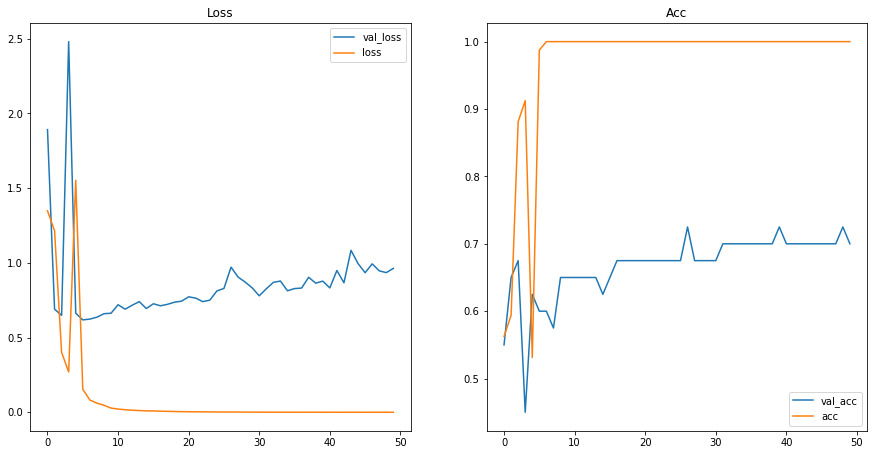

In [191]:
plot_history(history)

评估模型的效果，和之前的效果相比略有下降，主要原因在于词向量的参数过大，但是模型参数很小。

In [190]:
model.evaluate(x_test, y_test, batch_size=1024)

25000/25000 [==============================] - 0s 2us/step


[1.3159348347854614, 0.5683999999809265]

### 5. RNN
循环神经网络是处理序列数据的非常有效的一种模型，之前的我们学习过的神经网络没有记忆的功能，他们单独的处理每一个输入和输出，这样在处理序列数据中丢失大量的信息，从而导致结果下降。之前我们使用的方法叫做前馈网络 MLP。现在我们常识使用 RNN 解决这个问题，并查看效果上的变化。

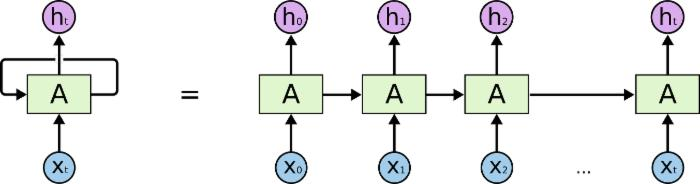

不同于之前的前馈网络，循环网络处理序列的方式是遍历所有的序列元素，在每一部保存历史状态。我们先介绍一下 tensorflow(keras) 中 RNN 网络的使用方法

In [35]:
from keras.layers import SimpleRNN

* 每一个 SimpleRNN 接受 (batch_size, timesteps, input_features) shape 的张量，并循环处理保存内部状态。
* return_sequences 参数控制返回的结果是 (batch_size, output_features) 还是 (batch_size, timesteps, output_features)
* 参数控制隐藏层单元的数目

#### 5.1 SimpleRNN for IMDB

In [36]:
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [37]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, padding='post')

In [47]:
model = Sequential()
model.add(Embedding(max_features, 50))
model.add(SimpleRNN(50))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 505,101
Trainable params: 505,101
Non-trainable params: 0
_________________________________________________________________


In [48]:
rmsprop = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-06)
model.compile(optimizer=rmsprop, 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [49]:
history = model.fit(x_train, 
                    y_train,
                    epochs=50, 
                    batch_size=1024,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 4s 214us/step - loss: 0.6964 - acc: 0.5046 - val_loss: 0.6951 - val_acc: 0.5062
Epoch 2/50
20000/20000 [==============================] - 4s 185us/step - loss: 0.6890 - acc: 0.5355 - val_loss: 0.6936 - val_acc: 0.5126
Epoch 3/50
20000/20000 [==============================] - 4s 188us/step - loss: 0.6824 - acc: 0.5645 - val_loss: 0.6889 - val_acc: 0.5304
Epoch 4/50
20000/20000 [==============================] - 4s 186us/step - loss: 0.6715 - acc: 0.6045 - val_loss: 0.6747 - val_acc: 0.5908
Epoch 5/50
20000/20000 [==============================] - 4s 187us/step - loss: 0.6500 - acc: 0.6581 - val_loss: 0.6478 - val_acc: 0.6638
Epoch 6/50
20000/20000 [==============================] - 4s 184us/step - loss: 0.6193 - acc: 0.7025 - val_loss: 0.6117 - val_acc: 0.6968
Epoch 7/50
20000/20000 [==============================] - 4s 188us/step - loss: 0.5786 - acc: 0.7377 - val_loss: 0.5947 - v

In [51]:
model.evaluate(x_test, y_test, batch_size=1024)

25000/25000 [==============================] - 1s 35us/step


[0.3599996808338165, 0.85284]

#### 5.2 LSTM & GRU
RNN 是一个非常强大的工具，但是实际上 SimpleRNN 会面临非常严重的梯度消失现象，如下图所示

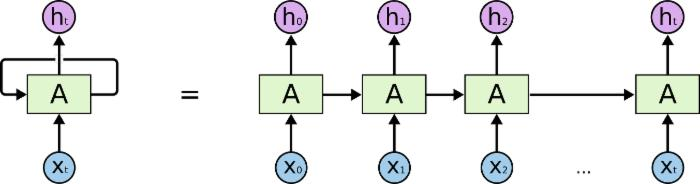

如果梯度值都是 0 ~ 1 之间的实数值的话，之前的梯度传播到后面会变得越来越小。从而导致训练后期网络训练不充分，为了解决这个问题，学者们提出了两个非常有用的网络架构 LSTM 和 GRU。他们成功的核心在于网络使用了 “门” 结构。

In [53]:
# LSTM & GRU
from keras.layers import LSTM, GRU

我们先来看 LSTM 的例子

In [183]:
max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, padding='post')

很明显，LSTM的参数量是之前的 SimpleRNN 的 4 倍，里面有4个门结构

In [57]:
model = Sequential()
model.add(Embedding(max_features, 50))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 520,251
Trainable params: 520,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-06)
model.compile(optimizer=rmsprop, 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(x_train, 
                    y_train,
                    epochs=50,
                    batch_size=1024,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 16s 809us/step - loss: 0.6927 - acc: 0.5313 - val_loss: 0.6925 - val_acc: 0.5384
Epoch 2/50
20000/20000 [==============================] - 15s 766us/step - loss: 0.6918 - acc: 0.5768 - val_loss: 0.6917 - val_acc: 0.5756
Epoch 3/50
20000/20000 [==============================] - 15s 760us/step - loss: 0.6907 - acc: 0.6123 - val_loss: 0.6907 - val_acc: 0.6018
Epoch 4/50
20000/20000 [==============================] - 15s 760us/step - loss: 0.6892 - acc: 0.6431 - val_loss: 0.6890 - val_acc: 0.6300
Epoch 5/50
20000/20000 [==============================] - 15s 763us/step - loss: 0.6868 - acc: 0.6752 - val_loss: 0.6864 - val_acc: 0.6554
Epoch 6/50
20000/20000 [==============================] - 15s 766us/step - loss: 0.6827 - acc: 0.7030 - val_loss: 0.6816 - val_acc: 0.6860
Epoch 7/50
20000/20000 [==============================] - 15s 767us/step - loss: 0.6746 - acc: 0.7287 - val_loss: 0.6

In [59]:
model.evaluate(x_test, y_test, batch_size=1024)

25000/25000 [==============================] - 3s 132us/step


[0.3590644604301453, 0.8627999995613098]

GRU 也是一种有门结构的RNN，但是GRU 相对于LSTM来说，可以在保证不损失效果的前提下提升训练速度，成为了很多的研究人员喜欢用的循环结构模型
GRU 有 3 个门，是 LSTM 的简化版，训练速度更快但是效果也很好。

In [60]:
model = Sequential()
model.add(Embedding(max_features, 50))
model.add(GRU(50))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 50)          500000    
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                15150     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 515,201
Trainable params: 515,201
Non-trainable params: 0
_________________________________________________________________


In [61]:
rmsprop = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-06)
model.compile(optimizer=rmsprop, 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(x_train, 
                    y_train,
                    epochs=50,
                    batch_size=1024,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 14s 678us/step - loss: 0.6928 - acc: 0.5147 - val_loss: 0.6924 - val_acc: 0.5436
Epoch 2/50
20000/20000 [==============================] - 13s 634us/step - loss: 0.6917 - acc: 0.5567 - val_loss: 0.6915 - val_acc: 0.5594
Epoch 3/50
20000/20000 [==============================] - 13s 637us/step - loss: 0.6905 - acc: 0.5889 - val_loss: 0.6904 - val_acc: 0.5790
Epoch 4/50
20000/20000 [==============================] - 13s 631us/step - loss: 0.6890 - acc: 0.6119 - val_loss: 0.6891 - val_acc: 0.5970
Epoch 5/50
20000/20000 [==============================] - 13s 631us/step - loss: 0.6871 - acc: 0.6358 - val_loss: 0.6873 - val_acc: 0.6112
Epoch 6/50
20000/20000 [==============================] - 13s 635us/step - loss: 0.6847 - acc: 0.6553 - val_loss: 0.6851 - val_acc: 0.6234
Epoch 7/50
20000/20000 [==============================] - 13s 633us/step - loss: 0.6817 - acc: 0.6706 - val_loss: 0.6

In [62]:
model.evaluate(x_test, y_test, batch_size=1024)

25000/25000 [==============================] - 3s 107us/step


[0.3214469873714447, 0.8702000001335144]

保存模型参数

In [63]:
model.save('./save/IMDB-GRU.h5')

### 6. 拓展实验，BERT

In [133]:
from bert_serving.client import BertClient
from keras.preprocessing import sequence
from keras.layers import Flatten, Dense, GRU, LSTM
bc = BertClient()

#### 6.1 BERT + MLP

In [148]:
max_features = 10000
maxlen = 50

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, padding='post')
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

In [149]:
def index2string(word_index, index):
    rest = [word_index.get(i, '<pad>') for i in index]
    try:
        return rest[:rest.index('<PAD>')]
    except:
        return rest

In [150]:
def reconstruct_dataset(word_index, x):
    # x_train: [samples, length]
    # new_x: [samples, length] but string
    new_x = []
    reverse_index = {value: key for key, value in word_index.items()}
    for sample in x:
        new_x.append(index2string(reverse_index, sample))
    return new_x

In [151]:
x_train_ = reconstruct_dataset(word_index, x_train)
x_test_ = reconstruct_dataset(word_index, x_test)

In [154]:
' '.join(x_train_[0])

"grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

In [155]:
train_emb = bc.encode([' '.join(i) for i in x_train_])
test_emb = bc.encode([' '.join(i) for i in x_test_])

/home/teacher/miniconda3/envs/lt/lib/python3.6/site-packages/bert_serving/client/__init__.py:286: UserWarning: some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


这一步运行非常慢，需要开 bert-as-service 占用大量的显存资源，我已经得到了结果，这里直接用就可以了

In [156]:
np.save('./save/train_bert_emb.npy', train_emb)
np.save('./save/test_bert_emb.npy', test_emb)

In [139]:
train_emb = np.load('./save/train_bert_emb.npy')
test_emb = np.load('./save/test_bert_emb.npy')

In [157]:
test_emb.shape, train_emb.shape

((25000, 768), (25000, 768))

In [158]:
# 构建模型开始分类
model = Sequential()
model.add(Dense(500, input_shape=(768,), activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 500)               384500    
_________________________________________________________________
dense_42 (Dense)             (None, 300)               150300    
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 301       
Total params: 535,101
Trainable params: 535,101
Non-trainable params: 0
_________________________________________________________________


In [159]:
# rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(train_emb, 
                    y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/50
22500/22500 [==============================] - 1s 53us/step - loss: 0.6250 - acc: 0.6577 - val_loss: 0.5929 - val_acc: 0.6796
Epoch 2/50
22500/22500 [==============================] - 1s 23us/step - loss: 0.5747 - acc: 0.6966 - val_loss: 0.5757 - val_acc: 0.6944
Epoch 3/50
22500/22500 [==============================] - 1s 24us/step - loss: 0.5560 - acc: 0.7119 - val_loss: 0.5709 - val_acc: 0.6980
Epoch 4/50
22500/22500 [==============================] - 1s 23us/step - loss: 0.5358 - acc: 0.7241 - val_loss: 0.5682 - val_acc: 0.7076
Epoch 5/50
22500/22500 [==============================] - 1s 24us/step - loss: 0.5082 - acc: 0.7422 - val_loss: 0.5680 - val_acc: 0.6992
Epoch 6/50
22500/22500 [==============================] - 1s 24us/step - loss: 0.4805 - acc: 0.7585 - val_loss: 0.6129 - val_acc: 0.7044
Epoch 7/50
22500/22500 [==============================] - 1s 24us/step - loss: 0.4422 - acc: 0.7846 - val_loss: 0.6002 - val_acc:

In [160]:
model.evaluate(test_emb, y_test, batch_size=1024)

25000/25000 [==============================] - 0s 4us/step


[2.7347980847167968, 0.6720399995994568]